# Weather Pattern Clustering

The weather datasets downloaded from NREL contain measurements of 19 different attributes taken at half-hour increments from various locations in and arround Pittsburgh, PA. I will attempt to explore these datasets through visualization first, and then through clustering. The ultimate goal is to be able to predict how weather patterns change, specifically GHI for solar power production. 

First, I will analyze just the Pittsburgh weather and time data.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle

# Load Pittsburgh-only data
with open('PIT_dict.pkl', 'rb') as f:
    PIT_dict = pickle.load(f)

PIT_df = PIT_dict['complete_data']
# Use only the weather-related columns, not time
cols = list(PIT_df.columns)


PIT_weather = PIT_df[cols].copy()

PIT_weather.head()


,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,PIT_Global Horizontal UV Irradiance (280-400nm),PIT_Global Horizontal UV Irradiance (295-385nm)
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.30,-11.0,990,0.0,0.0
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.32,-11.0,990,0.0,0.0
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.56,-11.0,990,0.0,0.0
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.57,-11.0,990,0.0,0.0
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.430146,-0.418299,78.91,-12.0,990,0.0,0.0


In [2]:
len(list(PIT_weather.columns))

19

Now I will look at the correlations between each column and then remove one of every two columns which have a correlation greater than 0.95 between them.

In [3]:
corr = PIT_weather.corr()
corr

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,PIT_Global Horizontal UV Irradiance (280-400nm),PIT_Global Horizontal UV Irradiance (295-385nm)
Time_X,1.000000e+00,3.700729e-17,-4.470169e-18,-4.464771e-18,-0.074965,-0.049157,-0.064789,-0.082888,-0.072622,-0.073546,-0.052457,1.024546e-17,0.039567,-0.044915,0.206283,-0.134640,0.046917,-0.062085,-0.061976
Time_Y,3.700729e-17,1.000000e+00,2.036644e-18,2.445463e-18,-0.729733,-0.581645,-0.720895,-0.803037,-0.895857,-0.837862,-0.002871,1.522043e-17,0.102929,0.007549,0.620450,-0.260143,0.002186,-0.700780,-0.699574
Day_X,-4.470169e-18,2.036644e-18,1.000000e+00,-2.641043e-17,0.061801,-0.015773,0.029884,0.083559,0.028914,0.062470,-0.246783,2.003478e-01,-0.181905,-0.021866,0.103655,-0.284838,-0.092027,0.031805,0.031998
Day_Y,-4.464771e-18,2.445463e-18,-2.641043e-17,1.000000e+00,-0.269574,-0.153451,-0.282085,-0.262357,-0.127156,-0.267833,-0.776137,4.379550e-01,-0.255425,-0.100215,0.131428,-0.795017,0.109945,-0.291357,-0.292126
PIT_DHI,-7.496546e-02,-7.297328e-01,6.180121e-02,-2.695735e-01,1.000000,0.377491,0.733204,0.847844,0.768282,0.866191,0.211782,-8.543919e-02,-0.040356,0.012269,-0.567217,0.434607,-0.061562,0.739780,0.739696
PIT_DNI,-4.915723e-02,-5.816452e-01,-1.577326e-02,-1.534505e-01,0.377491,1.000000,0.850507,0.461158,0.712300,0.630621,0.025416,-6.187142e-02,-0.024009,0.044345,-0.684879,0.324827,0.143100,0.771934,0.770293
PIT_GHI,-6.478891e-02,-7.208954e-01,2.988418e-02,-2.820848e-01,0.733204,0.850507,1.000000,0.721002,0.825390,0.892642,0.152216,-1.046049e-01,-0.019475,0.038610,-0.754335,0.475925,0.048206,0.959560,0.959361
PIT_Clearsky DHI,-8.288769e-02,-8.030374e-01,8.355925e-02,-2.623566e-01,0.847844,0.461158,0.721002,1.000000,0.803645,0.882743,0.228612,-6.492020e-02,-0.052251,0.008076,-0.540026,0.439601,-0.094738,0.728986,0.728399
PIT_Clearsky DNI,-7.262178e-02,-8.958567e-01,2.891407e-02,-1.271560e-01,0.768282,0.712300,0.825390,0.803645,1.000000,0.917468,0.054479,-5.418434e-02,-0.086817,0.028794,-0.722180,0.353599,0.016155,0.795526,0.793996
PIT_Clearsky GHI,-7.354553e-02,-8.378620e-01,6.246983e-02,-2.678327e-01,0.866191,0.630621,0.892642,0.882743,0.917468,1.000000,0.172471,-1.009607e-01,-0.048371,0.030250,-0.709215,0.466940,-0.036121,0.890524,0.890439


In [4]:
# Create bool numpy array to signify whether a column should be kept or not
columns = np.full((corr.shape[0],), True, dtype=bool)
# Iterate over all columns of raw data checking the correlation with other columns
# If the correlation is over the threshold, then elimate one of the two columsn
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
# Create a new dataframe with only the columns not highly correlated with another
selected_columns = PIT_weather.columns[columns]
PIT_weather = PIT_weather[selected_columns]
PIT_weather.head()


,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.30,-11.0,990
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.32,-11.0,990
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.56,-11.0,990
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.57,-11.0,990
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.430146,-0.418299,78.91,-12.0,990


In [5]:
len(list(PIT_weather.columns))

17

This process removed 2 columns.

## Data Visualization

I will now look at the distribution of a select few attributes.

In [6]:
# Get min and max values for each attribute of interest
DHI_min = PIT_weather["PIT_DHI"].min()
DNI_min = PIT_weather["PIT_DNI"].min()
GHI_min = PIT_weather["PIT_GHI"].min()
DHI_max = PIT_weather["PIT_DHI"].max()
DNI_max = PIT_weather["PIT_DNI"].max()
GHI_max = PIT_weather["PIT_GHI"].max()

Wind_X_min = PIT_weather["PIT_Wind_X"].min()
Wind_Y_min = PIT_weather["PIT_Wind_Y"].min()
Wind_X_max = PIT_weather["PIT_Wind_X"].max()
Wind_Y_max = PIT_weather["PIT_Wind_Y"].max()

DP_min = PIT_weather["PIT_Dew Point"].min()
RH_min = PIT_weather["PIT_Relative Humidity"].min()
DP_max = PIT_weather["PIT_Dew Point"].max()
RH_max = PIT_weather["PIT_Relative Humidity"].max()



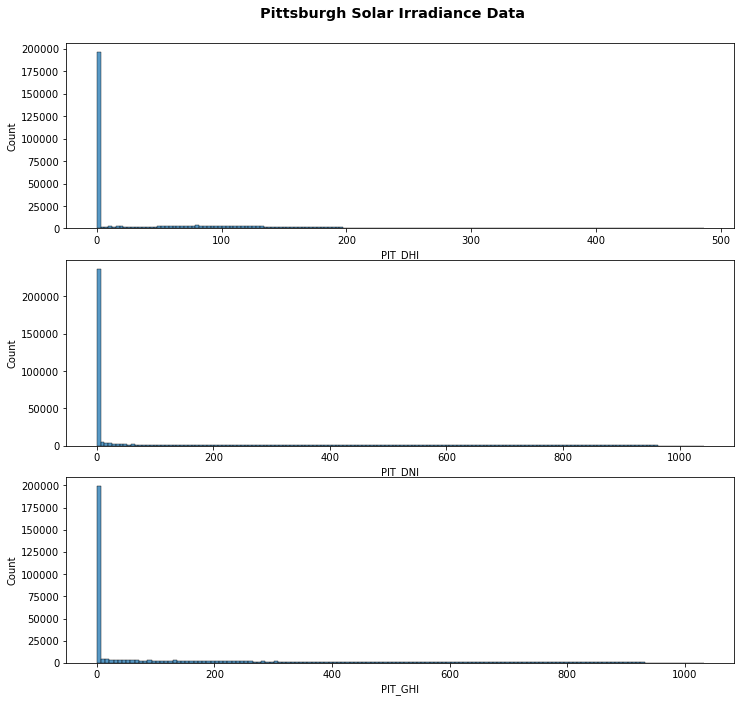

In [7]:
# Plot histograms of solar irradiance measurements
fig, axs = plt.subplots(nrows=3, figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Solar Irradiance Data', weight='bold', size='x-large')

sns.histplot(data=PIT_weather, x='PIT_DHI', ax=axs[0])
sns.histplot(data=PIT_weather, x='PIT_DNI', ax=axs[1])
sns.histplot(data=PIT_weather, x='PIT_GHI', ax=axs[2])
plt.show()

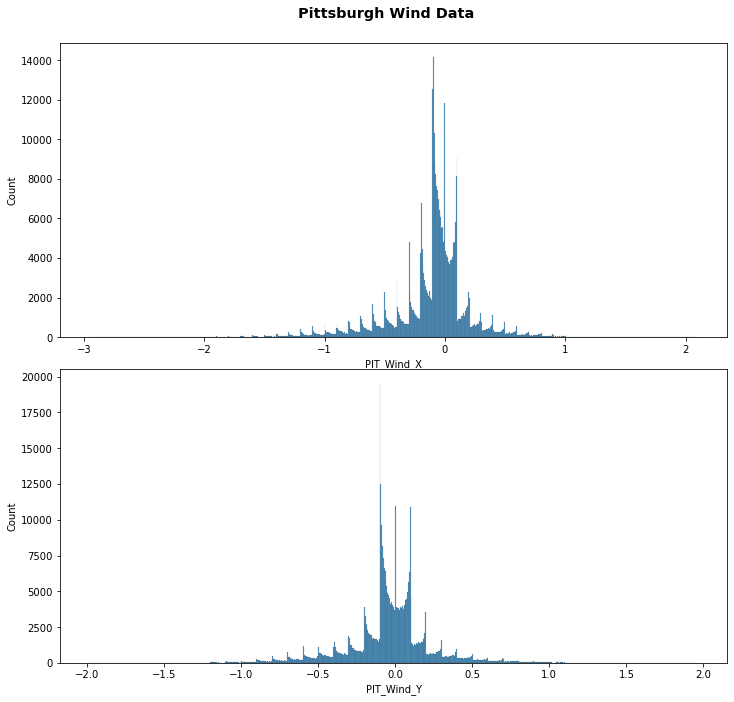

In [8]:
# Plot histograms of wind measurements
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Wind Data', weight='bold', size='x-large')

sns.histplot(data=PIT_weather, x='PIT_Wind_X', ax=axs[0])
sns.histplot(data=PIT_weather, x='PIT_Wind_Y', ax=axs[1])
plt.show()

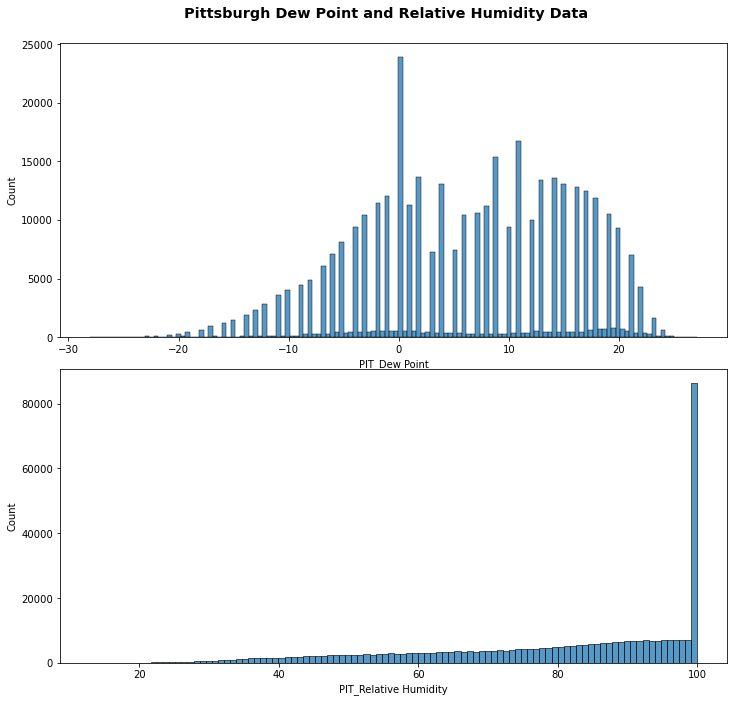

In [9]:
# Plot histograms of dew point and humidity measurements
fig, axs = plt.subplots(nrows=2, figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Dew Point and Relative Humidity Data', weight='bold', size='x-large')

sns.histplot(data=PIT_weather, x='PIT_Dew Point', ax=axs[0])
sns.histplot(data=PIT_weather, x='PIT_Relative Humidity', ax=axs[1])
plt.show()

Some features to take note of in these distributions are first, the very high prominence of zero values in all of the solar irradiance data columns. These are largely due to measurements made at night. 

The wind data has an interesting bimodal distribution with most of the data showing wind from the west and the south.

The dew point has a sharp peak at 0 while the relative humidity has an even sharper peak at 100. These seem to be due to incorrectly recorded data as these peaks don't seem to make much sense. However, it would be difficult to sort out the correct data from the erroneous data so I will leave it be for now. 

# Clustering

Now I will attempt to cluster the Pittsburgh weather and time data into discrete groups. First, the data needs to all be adjusted to be on similar scales. We don't want one feature having a range of 1000 and another a range of 100. I will use a simple min-max scaler to bring all data between 0 and 1.

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Create minmaxscaler object and fit and transform the weather data
scaler = MinMaxScaler()
scaled_PIT_weather = scaler.fit_transform(PIT_weather)

Now it's time to cluster the data. To select the number of clusters, I will use the elbow method. The KMeans algorithm will be applied multiple times, with different k values each time and the inertia value for each iteration saved. These inertia values will then be plotted to see where the inertia starts leveling off.

In [11]:
from sklearn.cluster import KMeans

# Create empty array to store sum of squared distances for differnt k values
sum_of_squared_distances = []

# Set range of k values to attempt
K = range(2,10)
for k in K:
    # Create K-means clustering model
    k_means = KMeans(n_clusters=k)
    # Fit the model to the scaled data, and assign all instances to their cluster
    preds = k_means.fit_predict(scaled_PIT_weather)
    # Get and store the sum of squared distances of samples
    # to their closest cluster center
    sum_of_squared_distances.append(k_means.inertia_)
    

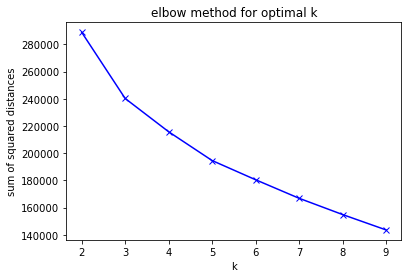

In [12]:
# Plot sum of sqared distances vs k-value to determine optimal k
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum of squared distances')
plt.title('elbow method for optimal k')
plt.show()

From this plot, it appears that a k value of 4 may be the optimal selection.

I will display the centers of each of these clusters below.

In [13]:
# Build and fit a model using the optimal k-value selected in previous step
k_means = KMeans(n_clusters=4, random_state=15217)
model = k_means.fit(scaled_PIT_weather)
# Store the locations of the cluster centers in non-scaled attribute values
centers = scaler.inverse_transform(model.cluster_centers_)


In [14]:
# Define function that creates a dataframe with a column for cluster number
def pd_centers(cols_of_interest, centers):
    colNames = list(cols_of_interest)
    colNames.append('prediction')
    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]
    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P
P = pd_centers(PIT_weather.columns, centers)
P

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,prediction
0,-0.644423,0.515678,-0.085118,-0.074583,10.383834,27.172082,15.117038,13.549374,65.153143,28.042646,8.588256,0.114722,-0.060421,-0.033669,88.174540,11.274581,980.628696,0
1,-0.077703,-0.763649,-0.020989,-0.252921,180.802560,432.098229,453.185500,134.924474,744.280304,612.709818,8.762174,0.129300,-0.114581,-0.031808,59.956407,18.059348,980.854142,1
2,0.743875,0.369051,-0.060260,-0.049516,11.382462,30.099371,16.857482,15.116918,77.715941,33.412863,7.176132,0.114316,-0.050991,-0.058344,93.882150,8.704199,980.910714,2
3,0.005406,0.034728,0.328142,0.815788,41.643030,99.720414,77.218537,40.148996,236.654315,130.426880,-6.610493,0.857638,-0.359577,-0.039202,81.742880,-3.811862,981.386828,3


It appears that the solar irradiance is a large factor in separating these clusters. Let's find the assigned cluster of each datapoint and inspect the distribution of the same attributes viewed before for each cluster.

In [15]:
# Predict the cluster for each data instance
predict = model.predict(scaled_PIT_weather)
# Convert predictions to a pandas series sharing an index with PIT_weather
predict = pd.Series(predict, index=PIT_weather.index)
# Add this series to the PIT_weather dataFrame as a new column
PIT_weather['Cluster'] = predict
PIT_weather.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI,PIT_DNI,PIT_GHI,PIT_Clearsky DHI,PIT_Clearsky DNI,PIT_Clearsky GHI,PIT_Dew Point,PIT_Surface Albedo,PIT_Wind_X,PIT_Wind_Y,PIT_Relative Humidity,PIT_Temperature,PIT_Pressure,Cluster
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.30,-11.0,990,3
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.524772,-0.290886,81.32,-11.0,990,3
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.56,-11.0,990,3
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.508829,-0.317952,79.57,-11.0,990,3
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,-14.0,0.866,-0.430146,-0.418299,78.91,-12.0,990,3


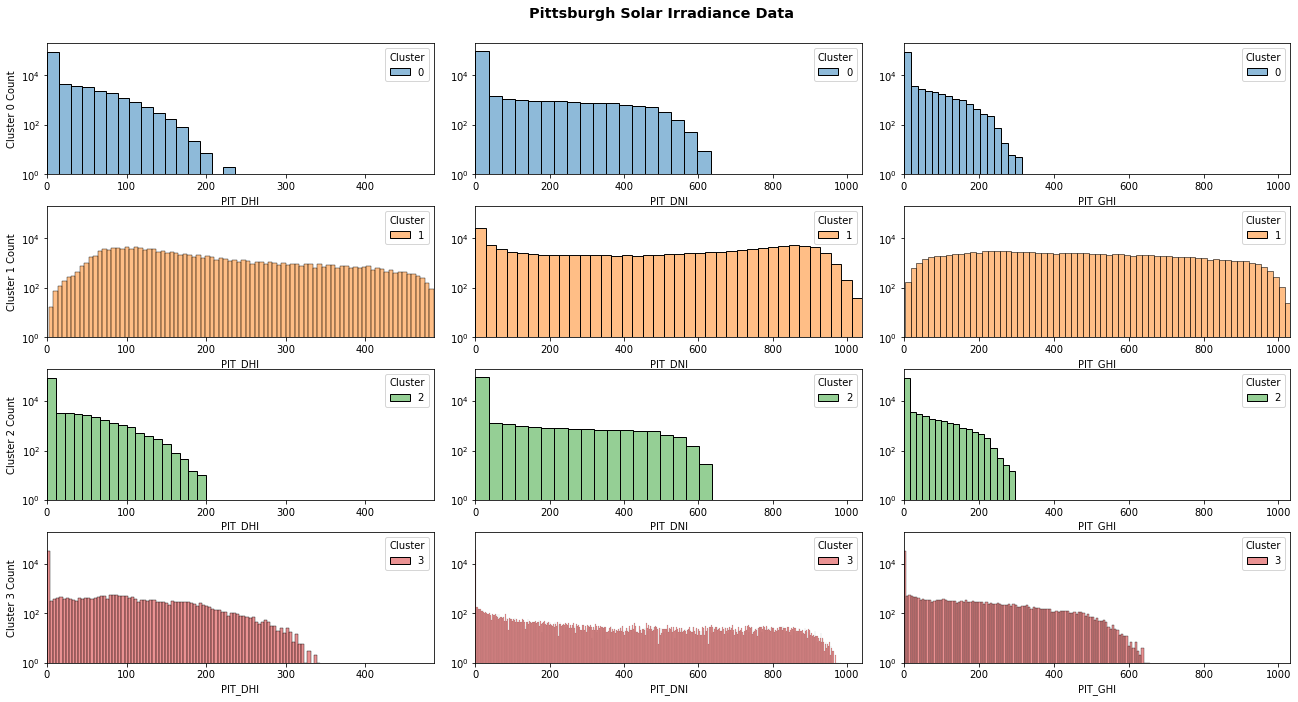

In [16]:
# Plot histograms of irradiance measurements for each cluster
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(18,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Solar Irradiance Data', weight='bold', size='x-large')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_DHI', ax=axs[0,0], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DHI_min, DHI_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_DNI', ax=axs[0,1], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DNI_min, DNI_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_GHI', ax=axs[0,2], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(GHI_min, GHI_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_DHI', ax=axs[1,0], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DHI_min, DHI_max), ylim=(1,200000), ylabel='Cluster 1 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_DNI', ax=axs[1,1], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DNI_min, DNI_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_GHI', ax=axs[1,2], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(GHI_min, GHI_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_DHI', ax=axs[2,0], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DHI_min, DHI_max), ylim=(1,200000), ylabel='Cluster 2 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_DNI', ax=axs[2,1], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DNI_min, DNI_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_GHI', ax=axs[2,2], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(GHI_min, GHI_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_DHI', ax=axs[3,0], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DHI_min, DHI_max), ylim=(1,200000), ylabel='Cluster 3 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_DNI', ax=axs[3,1], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DNI_min, DNI_max), ylim=(1,200000), ylabel='')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_GHI', ax=axs[3,2], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(GHI_min, GHI_max), ylim=(1,200000), ylabel='')

plt.show()

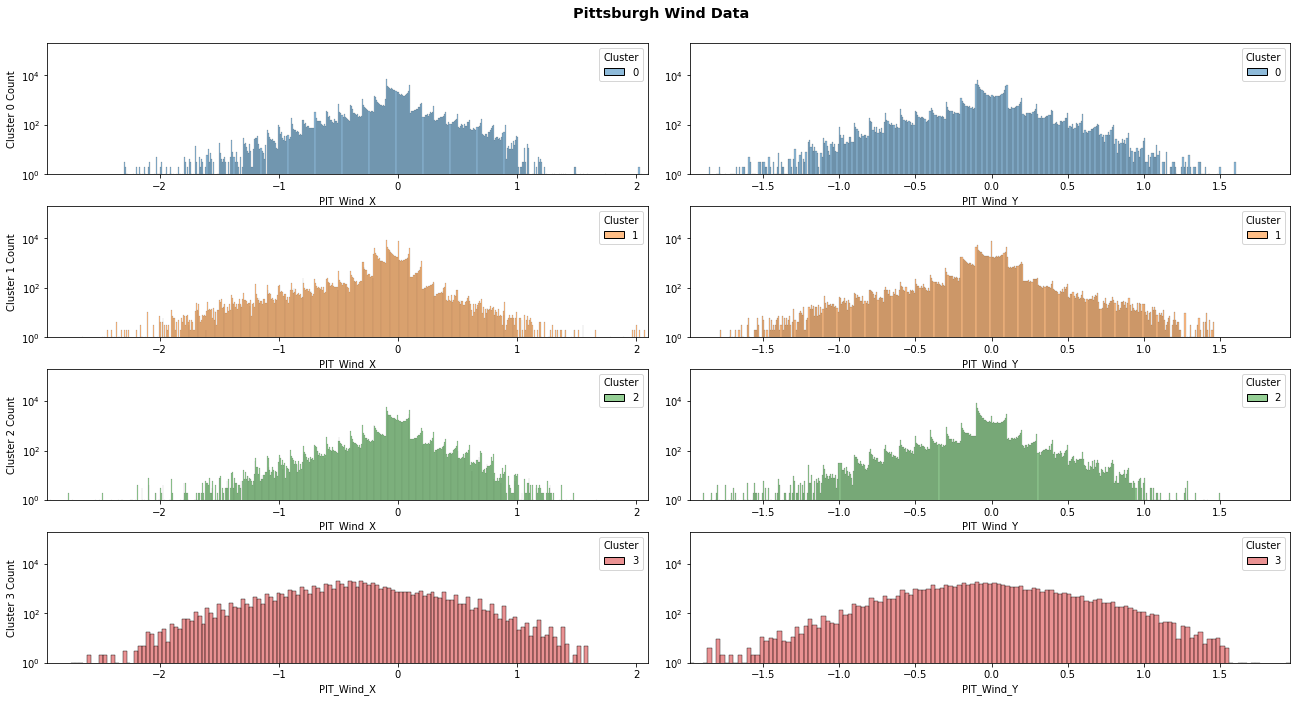

In [17]:
# Plot histograms of wind measurements for each cluster
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Wind Data', weight='bold', size='x-large')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Wind_X', ax=axs[0,0], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_X_min, Wind_X_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Wind_Y', ax=axs[0,1], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_Y_min, Wind_Y_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Wind_X', ax=axs[1,0], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_X_min, Wind_X_max), ylim=(1,200000), ylabel='Cluster 1 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Wind_Y', ax=axs[1,1], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_Y_min, Wind_Y_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Wind_X', ax=axs[2,0], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_X_min, Wind_X_max), ylim=(1,200000), ylabel='Cluster 2 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Wind_Y', ax=axs[2,1], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_Y_min, Wind_Y_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Wind_X', ax=axs[3,0], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_X_min, Wind_X_max), ylim=(1,200000), ylabel='Cluster 3 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Wind_Y', ax=axs[3,1], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(Wind_Y_min, Wind_Y_max), ylim=(1,200000), ylabel='')
    
plt.show()

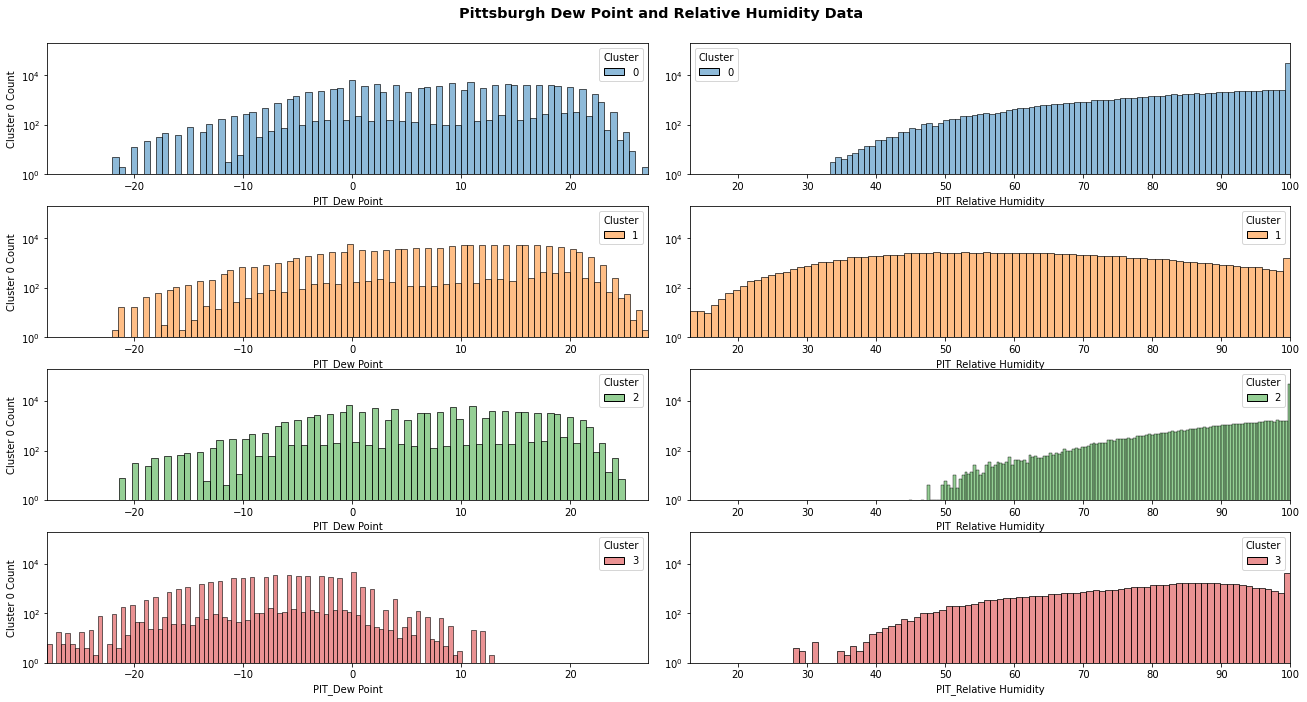

In [18]:
# Plot histograms of dew point and humidity measurements for each cluster
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Dew Point and Relative Humidity Data', weight='bold', size='x-large')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Dew Point', ax=axs[0,0], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DP_min, DP_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x='PIT_Relative Humidity', ax=axs[0,1], palette=["C0"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(RH_min, RH_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Dew Point', ax=axs[1,0], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DP_min, DP_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x='PIT_Relative Humidity', ax=axs[1,1], palette=["C1"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(RH_min, RH_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Dew Point', ax=axs[2,0], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DP_min, DP_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x='PIT_Relative Humidity', ax=axs[2,1], palette=["C2"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(RH_min, RH_max), ylim=(1,200000), ylabel='')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Dew Point', ax=axs[3,0], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(DP_min, DP_max), ylim=(1,200000), ylabel='Cluster 0 Count')
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x='PIT_Relative Humidity', ax=axs[3,1], palette=["C3"], hue='Cluster', log_scale=(False, True))
g.set(xlim=(RH_min, RH_max), ylim=(1,200000), ylabel='')

plt.show()

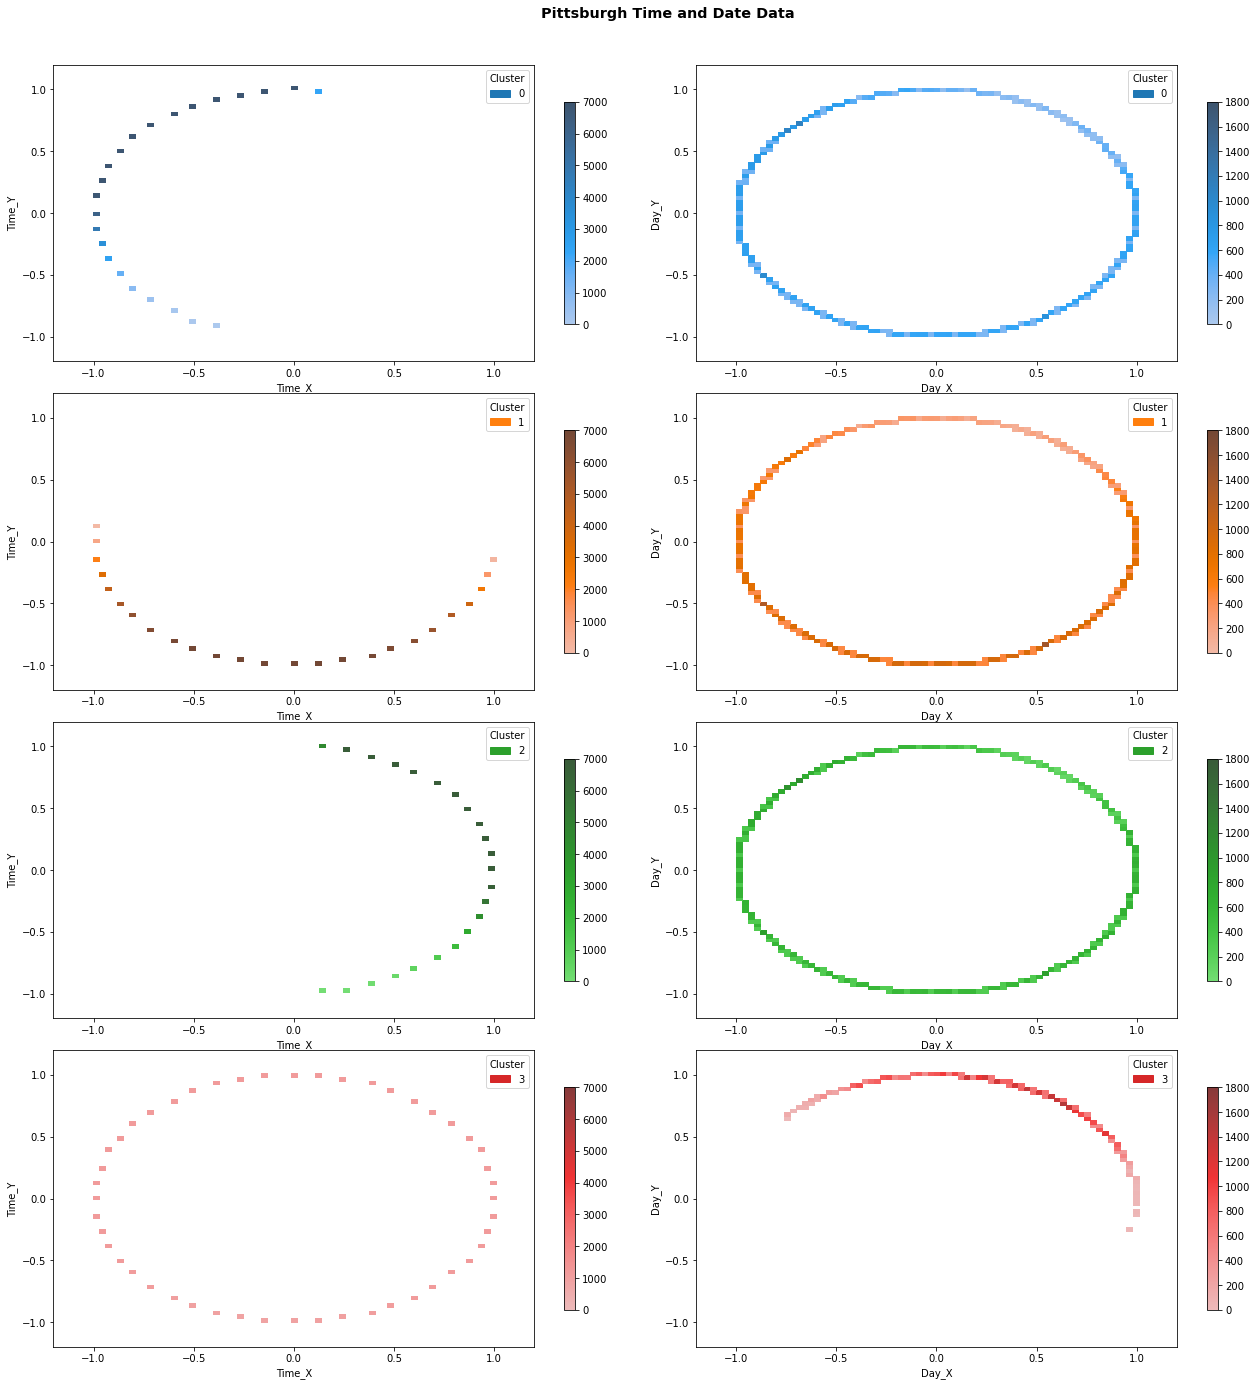

In [19]:
# Plot 2-histograms of time and date values for each cluster
# where the number of instances is represented by the hue 
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18,20))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Pittsburgh Time and Date Data', weight='bold', size='x-large')

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x="Time_X", y="Time_Y", ax=axs[0,0], binwidth=0.03,
               palette = ["C0"], cbar=True, cbar_kws=dict(shrink=.75), vmax=7000, hue='Cluster')
g.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 0], x="Day_X", y="Day_Y", ax=axs[0,1], binwidth=0.03, 
               palette = ["C0"], cbar=True, cbar_kws=dict(shrink=.75), vmax=1800, hue='Cluster')
g.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x="Time_X", y="Time_Y", ax=axs[1,0], binwidth=0.03, 
               palette = ["C1"], cbar=True, cbar_kws=dict(shrink=.75), vmax=7000, hue='Cluster')
g.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 1], x="Day_X", y="Day_Y", ax=axs[1,1], binwidth=0.03, 
               palette = ["C1"], cbar=True, cbar_kws=dict(shrink=.75), vmax=1800, hue='Cluster')
g.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x="Time_X", y="Time_Y", ax=axs[2,0], binwidth=0.03, 
               palette = ["C2"], cbar=True, cbar_kws=dict(shrink=.75), vmax=7000, hue='Cluster')
g.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 2], x="Day_X", y="Day_Y", ax=axs[2,1], binwidth=0.03, 
               palette = ["C2"], cbar=True, cbar_kws=dict(shrink=.75), vmax=1800, hue='Cluster')
g.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))

g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x="Time_X", y="Time_Y", ax=axs[3,0], binwidth=0.03, 
               palette = ["C3"], cbar=True, cbar_kws=dict(shrink=.75), vmax=7000, hue='Cluster')
g.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
g=sns.histplot(data=PIT_weather[PIT_weather['Cluster'] == 3], x="Day_X", y="Day_Y", ax=axs[3,1], binwidth=0.03, 
               palette = ["C3"], cbar=True, cbar_kws=dict(shrink=.75), vmax=1800, hue='Cluster')
g.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))

plt.show()

On a log scale, it may be a bit difficult to determine the relative sizes of the clusters. We can count how many members are in each cluster and list them.

In [20]:
# Count the number of instances in each cluster
count_0 = (PIT_weather["Cluster"] == 0).sum()
count_1 = (PIT_weather["Cluster"] == 1).sum()
count_2 = (PIT_weather["Cluster"] == 2).sum()
count_3 = (PIT_weather["Cluster"] == 3).sum()

print(f'Cluster 0 has {count_0:,} members\n\
Cluster 1 has {count_1:,} members\n\
Cluster 2 has {count_2:,} members\n\
Cluster 3 has {count_3:,} members\n')

Cluster 0 has 104,600 members
Cluster 1 has 123,206 members
Cluster 2 has 103,580 members
Cluster 3 has 54,054 members



Now I'm interested in the transition probabilities between clusters over a four-hour time period.

In [21]:
# Transition matrix. Rows are FROM and columns are TO
# hourly_transitions[2, 1] is the number of transitions FROM cluster 2 TO cluster 1
hourly_transitions = np.zeros((4, 4))

for i in range(8, PIT_weather['Cluster'].shape[0]):
    cluster_from = PIT_weather['Cluster'][i-8]
    cluster_to = PIT_weather['Cluster'][i]
    hourly_transitions[cluster_from, cluster_to] += 1

hourly_transitions

array([[4.8717e+04, 0.0000e+00, 5.4858e+04, 1.0170e+03],
       [5.4545e+04, 6.6639e+04, 0.0000e+00, 2.0220e+03],
       [9.9000e+01, 5.4794e+04, 4.8684e+04, 3.0000e+00],
       [1.2390e+03, 1.7730e+03, 3.8000e+01, 5.1004e+04]])

In [22]:
# Normalize the transition probabilities
hourly_transitions_norm = hourly_transitions / hourly_transitions.sum(axis=1)[:,None]
np.set_printoptions(suppress=True)
hourly_transitions_norm

array([[0.46578132, 0.        , 0.52449518, 0.0097235 ],
       [0.44271383, 0.54087463, 0.        , 0.01641154],
       [0.00095578, 0.52900174, 0.47001352, 0.00002896],
       [0.02292152, 0.03280053, 0.000703  , 0.94357494]])

From this we see that cluster 3 is very likely to transition to itself. The inter-cluster transition with the highest probability is 2 -> 1 followed closely by 0 -> 2.

## Visualization of Hourly Cluster Transitions

The following plot displays the transition probabilities between clusters over an hour. The size of the clusters is proportional to the number of instances in that cluster. The arrow sizes are proportional to the conditional probability of that transition given the initial instance is in the starting cluster.

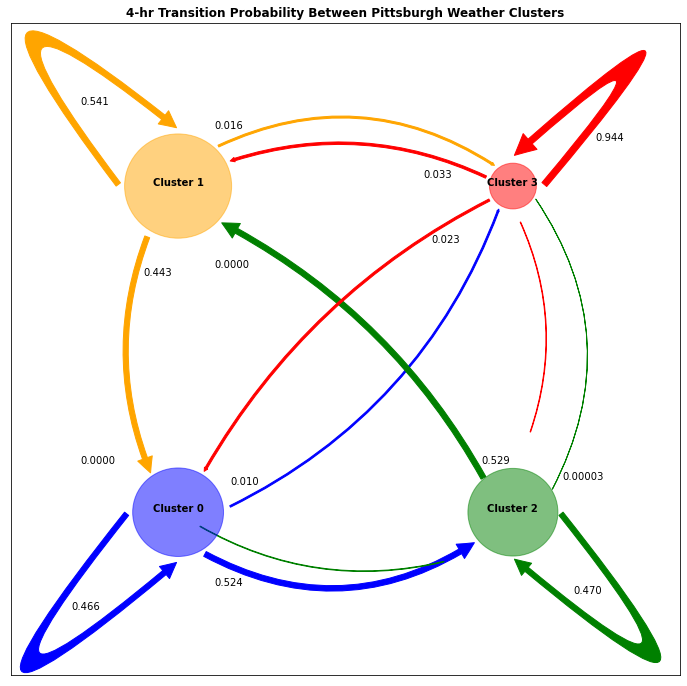

In [23]:
import matplotlib.patches as patches

total_count = count_0 + count_1 + count_2 + count_3
norm_count_0 = count_0/total_count
norm_count_1 = count_1/total_count
norm_count_2 = count_2/total_count
norm_count_3 = count_3/total_count

cluster0 = plt.Circle((0,0), norm_count_0, color='b', alpha=0.5)
cluster1 = plt.Circle((0,2), norm_count_1, color='orange', alpha=0.5)
cluster2 = plt.Circle((2,0), norm_count_2, color='g', alpha=0.5)
cluster3 = plt.Circle((2,2), norm_count_3, color='r', alpha=0.5)

fig, ax = plt.subplots(figsize=(12,12))

ax.add_artist(cluster0)
plt.text(0, 0, "Cluster 0", horizontalalignment='center', fontweight='bold')
ax.add_artist(cluster1)
plt.text(0, 2, "Cluster 1", horizontalalignment='center', fontweight='bold')
ax.add_artist(cluster2)
plt.text(2, 0, "Cluster 2", horizontalalignment='center', fontweight='bold')
ax.add_artist(cluster3)
plt.text(2, 2, "Cluster 3", horizontalalignment='center', fontweight='bold')

tw_mult = 3
hw_mult = 5
hl_mult = 5

from numpy import errstate,isneginf,isinf,array

with errstate(divide='ignore'):
    tw = np.log10(hourly_transitions_norm)
    hw = np.log10(hourly_transitions_norm)
    hl = np.log10(hourly_transitions_norm)


tw[isneginf(tw)] = np.inf
hw[isneginf(hw)] = np.inf
hl[isneginf(hl)] = np.inf

tw += (-(tw.min()) + 1)
hw += (-(hw.min()) + 1)
hl += (-(hl.min()) + 1)

tw[isinf(tw)] = 0
hw[isinf(hw)] = 0
hl[isinf(hl)] = 0

tw = (tw/3)**tw_mult
hw = (hw/3)**hw_mult
hl = (hl/3)**hl_mult

zero_zero= patches.FancyArrowPatch((-0.3, 0), (0, -0.3), color='b',
                                   arrowstyle=f"simple, tail_width={tw[0,0]}, head_width={hw[0,0]}, head_length={hl[0,0]}", 
                                   connectionstyle='arc3,rad=5')
zero_one = patches.FancyArrowPatch((-0.25, 0.15), (-0.25, 1.78), color='b',
                                   arrowstyle=f"simple, tail_width={tw[0,1]}, head_width={hw[0,1]}, head_length={hl[0,1]}", 
                                   connectionstyle='arc3,rad=-0.3')
zero_two = patches.FancyArrowPatch((0.15, -0.25), (1.78, -0.18), color='b',
                                   arrowstyle=f"simple, tail_width={tw[0,2]}, head_width={hw[0,2]}, head_length={hl[0,2]}", 
                                   connectionstyle='arc3,rad=0.3')
zero_three = patches.FancyArrowPatch((0.3, 0.03), (1.92, 1.87), color='b',
                                   arrowstyle=f"simple, tail_width={tw[0,3]}, head_width={hw[0,3]}, head_length={hl[0,3]}", 
                                   connectionstyle='arc3,rad=0.2')

one_zero= patches.FancyArrowPatch((-0.18, 1.7), (-0.16, 0.23), color='orange',
                                   arrowstyle=f"simple, tail_width={tw[1,0]}, head_width={hw[1,0]}, head_length={hl[1,0]}", 
                                   connectionstyle='arc3,rad=0.2')
one_one = patches.FancyArrowPatch((-0.35, 2), (0, 2.35), color='orange',
                                   arrowstyle=f"simple, tail_width={tw[1,1]}, head_width={hw[1,1]}, head_length={hl[1,1]}", 
                                   connectionstyle='arc3,rad=-4')
one_two = patches.FancyArrowPatch((0.1, 1.68), (1.75, 0.1), color='orange',
                                   arrowstyle=f"simple, tail_width={tw[1,2]}, head_width={hw[1,2]}, head_length={hl[1,2]}", 
                                   connectionstyle='arc3,rad=0.2')
one_three = patches.FancyArrowPatch((0.23, 2.24), (1.9, 2.12), color='orange',
                                   arrowstyle=f"simple, tail_width={tw[1,3]}, head_width={hw[1,3]}, head_length={hl[1,3]}", 
                                   connectionstyle='arc3,rad=-0.28')

two_zero= patches.FancyArrowPatch((1.6, -0.3), (0.12, -0.08), color='g',
                                   arrowstyle=f"simple, tail_width={tw[2,0]}, head_width={hw[2,0]}, head_length={hl[2,0]}", 
                                   connectionstyle='arc3,rad=-0.2')
two_one = patches.FancyArrowPatch((1.83, 0.2), (0.25, 1.78), color='g',
                                   arrowstyle=f"simple, tail_width={tw[2,1]}, head_width={hw[2,1]}, head_length={hl[2,1]}", 
                                   connectionstyle='arc3,rad=0.15')
two_two = patches.FancyArrowPatch((2.28, 0), (2, -0.28), color='g',
                                   arrowstyle=f"simple, tail_width={tw[2,2]}, head_width={hw[2,2]}, head_length={hl[2,2]}", 
                                   connectionstyle='arc3,rad=-5')
two_three = patches.FancyArrowPatch((2.23, 0.13), (2.13, 1.93), color='g',
                                   arrowstyle=f"simple, tail_width={tw[2,3]}, head_width={hw[2,3]}, head_length={hl[2,3]}", 
                                   connectionstyle='arc3,rad=0.3')

three_zero= patches.FancyArrowPatch((1.87, 1.92), (0.15, 0.24), color='r',
                                   arrowstyle=f"simple, tail_width={tw[3,0]}, head_width={hw[3,0]}, head_length={hl[3,0]}", 
                                   connectionstyle='arc3,rad=0.15')
three_one = patches.FancyArrowPatch((1.85, 2.05), (0.3, 2.15), color='r',
                                   arrowstyle=f"simple, tail_width={tw[3,1]}, head_width={hw[3,1]}, head_length={hl[3,1]}", 
                                   connectionstyle='arc3,rad=0.2')
three_two = patches.FancyArrowPatch((2.04, 1.79), (2.1, 0.48), color='r',
                                   arrowstyle=f"simple, tail_width={tw[3,2]}, head_width={hw[3,2]}, head_length={hl[3,2]}", 
                                   connectionstyle='arc3,rad=-0.2')
three_three = patches.FancyArrowPatch((2.18, 2), (2, 2.18), color='r',
                                   arrowstyle=f"simple, tail_width={tw[3,3]}, head_width={hw[3,3]}, head_length={hl[3,3]}", 
                                   connectionstyle='arc3,rad=7')

plt.text(-0.55, -0.6, f'{hourly_transitions_norm[0,0]:.3f}', horizontalalignment='center')
plt.text(-0.48, 0.3, f'{hourly_transitions_norm[0,1]:.4f}', horizontalalignment='center')
plt.text(0.3, -0.45, f'{hourly_transitions_norm[0,2]:.3f}', horizontalalignment='center')
plt.text(0.4, 0.17, f'{hourly_transitions_norm[0,3]:.3f}', horizontalalignment='center')

plt.text(-0.12, 1.45, f'{hourly_transitions_norm[1,0]:.3f}', horizontalalignment='center')
plt.text(-0.5, 2.5, f'{hourly_transitions_norm[1,1]:.3f}', horizontalalignment='center')
plt.text(0.32, 1.5, f'{hourly_transitions_norm[1,2]:.4f}', horizontalalignment='center')
plt.text(0.3, 2.35, f'{hourly_transitions_norm[1,3]:.3f}', horizontalalignment='center')

plt.text(1.9, 0.3, f'{hourly_transitions_norm[2,1]:.3f}', horizontalalignment='center')
plt.text(2.45, -0.5, f'{hourly_transitions_norm[2,2]:.3f}', horizontalalignment='center')
plt.text(2.42, 0.2, f'{hourly_transitions_norm[2,3]:.5f}', horizontalalignment='center')

plt.text(1.6, 1.65, f'{hourly_transitions_norm[3,0]:.3f}', horizontalalignment='center')
plt.text(1.55, 2.05, f'{hourly_transitions_norm[3,1]:.3f}', horizontalalignment='center')
plt.text(2.58, 2.28, f'{hourly_transitions_norm[3,3]:.3f}', horizontalalignment='center')

for a in [zero_zero, zero_one, zero_two, zero_three, one_zero, one_one, one_two, one_three, 
          two_zero, two_one, two_two, two_three, three_zero, three_one, three_two, three_three]:
    plt.gca().add_patch(a)

ax.set(xlim=(-1, 3), ylim=(-1, 3))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.title('4-hr Transition Probability Between Pittsburgh Weather Clusters', fontweight='bold')
plt.show()

## Multiple-City Weather Clustering

Now I will work with the weather data from the full-cities data. I will split the data into training, validation, and testing sets. I will check for correlations in the training set, remove columns with greather than 0.95 correlation, and then cluster the data.

Then, I will train a model to forecast the 4-hour ahead GHI in Pittsburgh based on these clusters

In [98]:
# Load full-cities data
with open('full_cities_dict.pkl', 'rb') as f:
    full_cities_dict = pickle.load(f)

full_cities_df = full_cities_dict['complete_data']

cols = list(full_cities_df.columns)

fc_weather = full_cities_df[cols].copy()

print(list(fc_weather.columns))

['Time_X', 'Time_Y', 'Day_X', 'Day_Y', 'PIT_DHI', 'PIT_DNI', 'PIT_GHI', 'PIT_Clearsky DHI', 'PIT_Clearsky DNI', 'PIT_Clearsky GHI', 'PIT_Dew Point', 'PIT_Surface Albedo', 'PIT_Wind_X', 'PIT_Wind_Y', 'PIT_Relative Humidity', 'PIT_Temperature', 'PIT_Pressure', 'PIT_Global Horizontal UV Irradiance (280-400nm)', 'PIT_Global Horizontal UV Irradiance (295-385nm)', 'BUT_DHI', 'BUT_DNI', 'BUT_GHI', 'BUT_Clearsky DHI', 'BUT_Clearsky DNI', 'BUT_Clearsky GHI', 'BUT_Dew Point', 'BUT_Surface Albedo', 'BUT_Wind_X', 'BUT_Wind_Y', 'BUT_Relative Humidity', 'BUT_Temperature', 'BUT_Pressure', 'BUT_Global Horizontal UV Irradiance (280-400nm)', 'BUT_Global Horizontal UV Irradiance (295-385nm)', 'CBG_DHI', 'CBG_DNI', 'CBG_GHI', 'CBG_Clearsky DHI', 'CBG_Clearsky DNI', 'CBG_Clearsky GHI', 'CBG_Dew Point', 'CBG_Surface Albedo', 'CBG_Wind_X', 'CBG_Wind_Y', 'CBG_Relative Humidity', 'CBG_Temperature', 'CBG_Pressure', 'CBG_Global Horizontal UV Irradiance (280-400nm)', 'CBG_Global Horizontal UV Irradiance (295-385n

In [99]:
# creates time-based columns to relect the desired features looking back in time and outputs the feature df and target df
def feature_target_split(df, look_back_steps, forecast_ahead_steps, target_col_name):
    
    feature_names = df.columns
    t_steps_back = range(look_back_steps + 1)
    time_features = pd.DataFrame()
    target_feature = pd.DataFrame()
    for feature in feature_names:
        if (feature == 'Day_X') or (feature == 'Day_Y') or (feature == 'Time_X') or (feature == 'Time_Y'):
            time_features[feature] = df[feature].iloc[look_back_steps : 0 - forecast_ahead_steps].reset_index(drop=True)
        else:
            for t_back in t_steps_back:
                t_feature_col_name = feature + "-" + str(t_back)
                time_features[t_feature_col_name] = df[feature].iloc[(look_back_steps - t_back) : 0 - forecast_ahead_steps - t_back].reset_index(drop=True)
    new_target_col_name = target_col_name + "+" + str(forecast_ahead_steps)
    target_feature[new_target_col_name] = df[target_col_name].iloc[look_back_steps + forecast_ahead_steps : ].reset_index(drop=True)

    return time_features, target_feature

In [100]:
# creates differerent datasets based on how many look-back measurements are used
features, target = feature_target_split(fc_weather, 0, 8, 'PIT_GHI')

Split the data into train, val and test sets

In [101]:
from sklearn.model_selection import train_test_split

# split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = \
train_test_split(features, target, test_size=0.2, shuffle=False)

# split train_val sets into train and val sets
X_train, X_val, y_train, y_val = \
train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

X_train_val.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train_val.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)


Find correlation betwen training set, remove columns with >= 0.95 correlation

In [102]:
X_train_corr = X_train.corr()
X_train_corr.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI-0,PIT_DNI-0,PIT_GHI-0,PIT_Clearsky DHI-0,PIT_Clearsky DNI-0,PIT_Clearsky GHI-0,...,YGT_Clearsky GHI-0,YGT_Dew Point-0,YGT_Surface Albedo-0,YGT_Wind_X-0,YGT_Wind_Y-0,YGT_Relative Humidity-0,YGT_Temperature-0,YGT_Pressure-0,YGT_Global Horizontal UV Irradiance (280-400nm)-0,YGT_Global Horizontal UV Irradiance (295-385nm)-0
Time_X,1.000000,0.000006,0.000003,0.000005,-0.076112,-0.050188,-0.065408,-0.083373,-0.071550,-0.073434,...,-0.082428,-0.049160,-0.000084,0.024064,-0.029652,0.203234,-0.129187,0.038277,-0.069891,-0.069771
Time_Y,0.000006,1.000000,0.000016,0.000027,-0.731208,-0.582880,-0.719720,-0.800097,-0.892567,-0.836613,...,-0.832794,-0.005477,0.000153,0.049586,0.006362,0.598333,-0.256340,0.000891,-0.692693,-0.691467
Day_X,0.000003,0.000016,1.000000,0.002671,0.060390,-0.017005,0.028479,0.080893,0.027477,0.061230,...,0.063101,-0.267714,0.235156,-0.174282,-0.020018,0.093795,-0.291901,-0.095970,0.033663,0.033851
Day_Y,0.000005,0.000027,0.002671,1.000000,-0.269678,-0.155401,-0.283707,-0.265153,-0.126962,-0.269050,...,-0.275869,-0.772879,0.500087,-0.283259,-0.120699,0.197448,-0.799981,0.081636,-0.303445,-0.304184
PIT_DHI-0,-0.076112,-0.731208,0.060390,-0.269678,1.000000,0.384488,0.734407,0.854490,0.766697,0.866042,...,0.867564,0.214111,-0.102401,0.019819,0.027458,-0.572952,0.436570,-0.052455,0.738398,0.738303


In [103]:
X_train_columns = np.full((X_train_corr.shape[0],), True, dtype=bool)

for i in range(X_train_corr.shape[0]):
    for j in range(i+1, X_train_corr.shape[0]):
        if X_train_corr.iloc[i,j] >= 0.95:
            if X_train_columns[j]:
                X_train_columns[j] = False
X_train_selected_columns = X_train.columns[X_train_columns]
X_train = X_train[X_train_selected_columns]
X_train.columns

Index(['Time_X', 'Time_Y', 'Day_X', 'Day_Y', 'PIT_DHI-0', 'PIT_DNI-0',
       'PIT_GHI-0', 'PIT_Clearsky DHI-0', 'PIT_Clearsky DNI-0',
       'PIT_Clearsky GHI-0', 'PIT_Dew Point-0', 'PIT_Surface Albedo-0',
       'PIT_Wind_X-0', 'PIT_Wind_Y-0', 'PIT_Relative Humidity-0',
       'PIT_Temperature-0', 'PIT_Pressure-0', 'BUT_DHI-0', 'BUT_DNI-0',
       'BUT_GHI-0', 'BUT_Surface Albedo-0', 'BUT_Wind_X-0', 'BUT_Wind_Y-0',
       'BUT_Pressure-0', 'CBG_DHI-0', 'CBG_DNI-0', 'CBG_GHI-0',
       'CBG_Surface Albedo-0', 'CBG_Wind_X-0', 'CBG_Wind_Y-0',
       'CBG_Relative Humidity-0', 'CBG_Pressure-0', 'ELV_DHI-0', 'ELV_DNI-0',
       'ELV_Surface Albedo-0', 'ELV_Wind_X-0', 'ELV_Wind_Y-0',
       'ELV_Pressure-0', 'GRE_DHI-0', 'GRE_DNI-0', 'GRE_GHI-0',
       'GRE_Surface Albedo-0', 'GRE_Wind_X-0', 'GRE_Wind_Y-0',
       'GRE_Pressure-0', 'JON_DHI-0', 'JON_DNI-0', 'JON_GHI-0',
       'JON_Surface Albedo-0', 'JON_Wind_X-0', 'JON_Wind_Y-0',
       'JON_Pressure-0', 'KIT_DHI-0', 'KIT_DNI-0', 'KIT_S

In [104]:
X_train.columns.shape

(98,)

Scale then cluster the training data

In [105]:
# scale data
X_train_scaler = MinMaxScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train).copy()

In [106]:
sum_of_squared_distances = []

K = range(1,10)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_train_scaled)
    sum_of_squared_distances.append(k_means.inertia_)

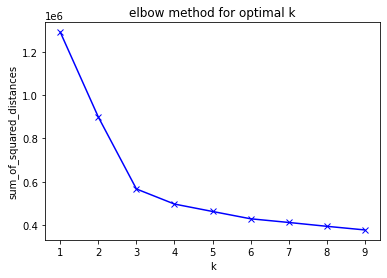

In [107]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [108]:
k_means = KMeans(n_clusters=3, random_state=15217)
model = k_means.fit(X_train_scaled)

In [109]:
X_train_predict = model.predict(X_train_scaled)
X_train_predict = pd.Series(X_train_predict, index=X_train.index)
X_train['Cluster'] = X_train_predict
X_train.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI-0,PIT_DNI-0,PIT_GHI-0,PIT_Clearsky DHI-0,PIT_Clearsky DNI-0,PIT_Clearsky GHI-0,...,WAS_Wind_Y-0,WAS_Pressure-0,WHE_DHI-0,WHE_DNI-0,WHE_Surface Albedo-0,WHE_Wind_Y-0,YGT_DHI-0,YGT_DNI-0,YGT_Surface Albedo-0,Cluster
0,0.000000,1.000000,0.017213,0.999852,0,0,0,0,0,0,...,-0.240877,980,0,0,0.866,-0.172930,0,0,0.866,2
1,0.130526,0.991445,0.017213,0.999852,0,0,0,0,0,0,...,-0.240877,980,0,0,0.866,-0.172930,0,0,0.866,2
2,0.258819,0.965926,0.017213,0.999852,0,0,0,0,0,0,...,-0.270120,980,0,0,0.866,-0.241468,0,0,0.866,2
3,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,...,-0.270120,980,0,0,0.866,-0.241468,0,0,0.866,2
4,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,...,-0.369816,980,0,0,0.866,-0.368745,0,0,0.866,2


Get proper columns of X_val. Scale val data and assign to clusters

In [110]:
X_val = X_val[X_train_selected_columns]
X_val.columns

Index(['Time_X', 'Time_Y', 'Day_X', 'Day_Y', 'PIT_DHI-0', 'PIT_DNI-0',
       'PIT_GHI-0', 'PIT_Clearsky DHI-0', 'PIT_Clearsky DNI-0',
       'PIT_Clearsky GHI-0', 'PIT_Dew Point-0', 'PIT_Surface Albedo-0',
       'PIT_Wind_X-0', 'PIT_Wind_Y-0', 'PIT_Relative Humidity-0',
       'PIT_Temperature-0', 'PIT_Pressure-0', 'BUT_DHI-0', 'BUT_DNI-0',
       'BUT_GHI-0', 'BUT_Surface Albedo-0', 'BUT_Wind_X-0', 'BUT_Wind_Y-0',
       'BUT_Pressure-0', 'CBG_DHI-0', 'CBG_DNI-0', 'CBG_GHI-0',
       'CBG_Surface Albedo-0', 'CBG_Wind_X-0', 'CBG_Wind_Y-0',
       'CBG_Relative Humidity-0', 'CBG_Pressure-0', 'ELV_DHI-0', 'ELV_DNI-0',
       'ELV_Surface Albedo-0', 'ELV_Wind_X-0', 'ELV_Wind_Y-0',
       'ELV_Pressure-0', 'GRE_DHI-0', 'GRE_DNI-0', 'GRE_GHI-0',
       'GRE_Surface Albedo-0', 'GRE_Wind_X-0', 'GRE_Wind_Y-0',
       'GRE_Pressure-0', 'JON_DHI-0', 'JON_DNI-0', 'JON_GHI-0',
       'JON_Surface Albedo-0', 'JON_Wind_X-0', 'JON_Wind_Y-0',
       'JON_Pressure-0', 'KIT_DHI-0', 'KIT_DNI-0', 'KIT_S

In [111]:
X_val_scaled = X_train_scaler.transform(X_val).copy()

In [112]:
X_val_predict = model.predict(X_val_scaled)
X_val_predict = pd.Series(X_val_predict, index=X_val.index)
X_val['Cluster'] = X_val_predict
X_val.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI-0,PIT_DNI-0,PIT_GHI-0,PIT_Clearsky DHI-0,PIT_Clearsky DNI-0,PIT_Clearsky GHI-0,...,WAS_Wind_Y-0,WAS_Pressure-0,WHE_DHI-0,WHE_DNI-0,WHE_Surface Albedo-0,WHE_Wind_Y-0,YGT_DHI-0,YGT_DNI-0,YGT_Surface Albedo-0,Cluster
0,0.500000,0.866025,0.493776,0.869589,0,0,0,0,0,0,...,0.099840,980,0,0,0.101,-0.004189,0,0,0.866,2
1,0.608761,0.793353,0.493776,0.869589,0,0,0,0,0,0,...,0.085577,980,0,0,0.101,-0.004189,0,0,0.866,2
2,0.707107,0.707107,0.493776,0.869589,0,0,0,0,0,0,...,0.021986,980,0,0,0.101,-0.059124,0,0,0.866,2
3,0.793353,0.608761,0.493776,0.869589,0,0,0,0,0,0,...,0.018322,980,0,0,0.101,-0.044343,0,0,0.866,2
4,0.866025,0.500000,0.493776,0.869589,0,0,0,0,0,0,...,-0.064398,980,0,0,0.101,-0.085707,0,0,0.866,2


Scale y_train and y_val

In [113]:
# scale data
y_train_scaler = MinMaxScaler()
y_train_scaled = y_train_scaler.fit_transform(y_train)
y_val_scaled = y_train_scaler.transform(y_val)

Split data into X_train_cluster_0, y_train_cluster_0, etc.

In [114]:
X_train_cluster_0 = X_train[X_train['Cluster'] == 0]
X_train_cluster_1 = X_train[X_train['Cluster'] == 1]
X_train_cluster_2 = X_train[X_train['Cluster'] == 2]

X_val_cluster_0 = X_val[X_val['Cluster'] == 0]
X_val_cluster_1 = X_val[X_val['Cluster'] == 1]
X_val_cluster_2 = X_val[X_val['Cluster'] == 2]

In [115]:
y_train_cluster_0 = y_train.iloc[X_train_cluster_0.index.values]
y_train_cluster_1 = y_train.iloc[X_train_cluster_1.index.values]
y_train_cluster_2 = y_train.iloc[X_train_cluster_2.index.values]

y_val_cluster_0 = y_val.iloc[X_val_cluster_0.index.values]
y_val_cluster_1 = y_val.iloc[X_val_cluster_1.index.values]
y_val_cluster_2 = y_val.iloc[X_val_cluster_2.index.values]

In [116]:
X_train_cluster_0 = X_train_cluster_0.drop(['Cluster'], axis=1)
X_train_cluster_1 = X_train_cluster_1.drop(['Cluster'], axis=1)
X_train_cluster_2 = X_train_cluster_2.drop(['Cluster'], axis=1)

X_val_cluster_0 = X_val_cluster_0.drop(['Cluster'], axis=1)
X_val_cluster_1 = X_val_cluster_1.drop(['Cluster'], axis=1)
X_val_cluster_2 = X_val_cluster_2.drop(['Cluster'], axis=1)

In [117]:
X_train_cluster_0.reset_index(inplace=True, drop=True)
X_train_cluster_1.reset_index(inplace=True, drop=True)
X_train_cluster_2.reset_index(inplace=True, drop=True)

y_train_cluster_0.reset_index(inplace=True, drop=True)
y_train_cluster_1.reset_index(inplace=True, drop=True)
y_train_cluster_2.reset_index(inplace=True, drop=True)

In [118]:
X_train_cluster_0_norm = X_train_scaler.transform(X_train_cluster_0)
X_train_cluster_1_norm = X_train_scaler.transform(X_train_cluster_1)
X_train_cluster_2_norm = X_train_scaler.transform(X_train_cluster_2)

y_train_cluster_0_norm = y_train_scaler.transform(y_train_cluster_0)
y_train_cluster_1_norm = y_train_scaler.transform(y_train_cluster_1)
y_train_cluster_2_norm = y_train_scaler.transform(y_train_cluster_2)

X_val_cluster_0_norm = X_train_scaler.transform(X_val_cluster_0)
X_val_cluster_1_norm = X_train_scaler.transform(X_val_cluster_1)
X_val_cluster_2_norm = X_train_scaler.transform(X_val_cluster_2)

y_val_cluster_0_norm = y_train_scaler.transform(y_val_cluster_0)
y_val_cluster_1_norm = y_train_scaler.transform(y_val_cluster_1)
y_val_cluster_2_norm = y_train_scaler.transform(y_val_cluster_2)


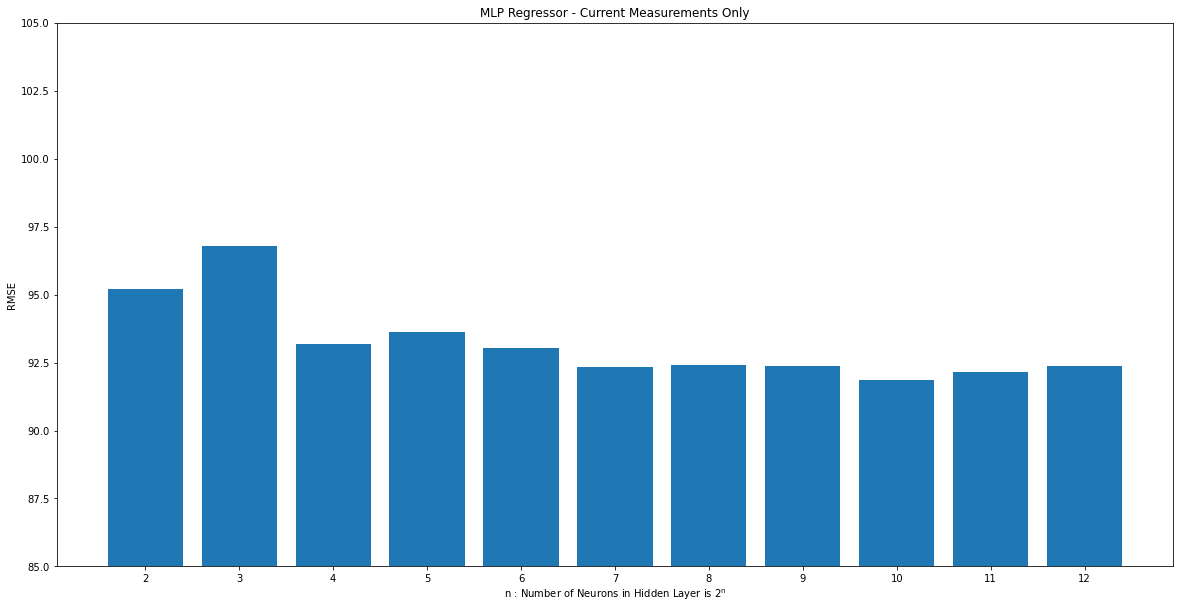

In [138]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

scores = []
scores_0 = []
scores_1 = []
scores_2 = []
num_neurons1 = range(2,13)
labels = []

for n1 in num_neurons1:
    model_0 = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
    model_1 = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
    model_2 = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
    
    model_0.fit(X_train_cluster_0_norm, y_train_cluster_0_norm.ravel())
    model_1.fit(X_train_cluster_1_norm, y_train_cluster_1_norm.ravel())
    model_2.fit(X_train_cluster_2_norm, y_train_cluster_2_norm.ravel())
    
    prediction_0 = model_0.predict(X_val_cluster_0_norm)
    prediction_1 = model_1.predict(X_val_cluster_1_norm)
    prediction_2 = model_2.predict(X_val_cluster_2_norm)

    prediction_0 = y_train_scaler.inverse_transform(prediction_0.reshape(-1,1))
    prediction_1 = y_train_scaler.inverse_transform(prediction_1.reshape(-1,1))
    prediction_2 = y_train_scaler.inverse_transform(prediction_2.reshape(-1,1))
    
    prediction = np.concatenate((prediction_0, prediction_1, prediction_2), axis=0)
    
    actual_0 = y_val_cluster_0
    actual_1 = y_val_cluster_1
    actual_2 = y_val_cluster_2
    
    actual = actual_0.append(actual_1, ignore_index=True)
    actual = actual.append(actual_2, ignore_index=True)
    
    score_0 = mean_squared_error(actual_0, prediction_0, squared=False)
    score_1 = mean_squared_error(actual_1, prediction_1, squared=False)
    score_2 = mean_squared_error(actual_2, prediction_2, squared=False)
    scores_0.append(score_0)
    scores_1.append(score_1)
    scores_2.append(score_2)
    scores.append(mean_squared_error(actual, prediction, squared=False))

    labels.append("{n1}".format(n1=n1))

fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current Measurements Only')
plt.xlabel('n : Number of Neurons in Hidden Layer is $\mathregular{2^{n}}$')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores)
plt.ylim(85, 105) 
plt.show()

# current and previous 3

In [139]:
# creates differerent datasets based on how many look-back measurements are used
features, target = feature_target_split(fc_weather, 3, 8, 'PIT_GHI')

In [140]:
from sklearn.model_selection import train_test_split

# split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = \
train_test_split(features, target, test_size=0.2, shuffle=False)

# split train_val sets into train and val sets
X_train, X_val, y_train, y_val = \
train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)

X_train_val.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train_val.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)


In [141]:
X_train_corr = X_train.corr()
X_train_corr.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI-0,PIT_DHI-1,PIT_DHI-2,PIT_DHI-3,PIT_DNI-0,PIT_DNI-1,...,YGT_Pressure-2,YGT_Pressure-3,YGT_Global Horizontal UV Irradiance (280-400nm)-0,YGT_Global Horizontal UV Irradiance (280-400nm)-1,YGT_Global Horizontal UV Irradiance (280-400nm)-2,YGT_Global Horizontal UV Irradiance (280-400nm)-3,YGT_Global Horizontal UV Irradiance (295-385nm)-0,YGT_Global Horizontal UV Irradiance (295-385nm)-1,YGT_Global Horizontal UV Irradiance (295-385nm)-2,YGT_Global Horizontal UV Irradiance (295-385nm)-3
Time_X,1.000000,0.000006,0.000005,0.000006,-0.076113,-0.170903,-0.262769,-0.350139,-0.050188,-0.125840,...,0.037200,0.035702,-0.069891,-0.159707,-0.246791,-0.329652,-0.069771,-0.159428,-0.246358,-0.329072
Time_Y,0.000006,1.000000,0.000019,0.000009,-0.731208,-0.715018,-0.686595,-0.646423,-0.582879,-0.571342,...,-0.009056,-0.013827,-0.692693,-0.677644,-0.651002,-0.613220,-0.691467,-0.676445,-0.649849,-0.612133
Day_X,0.000005,0.000019,1.000000,0.002674,0.060388,0.060388,0.060388,0.060388,-0.017006,-0.017006,...,-0.095919,-0.095892,0.033661,0.033661,0.033661,0.033661,0.033850,0.033850,0.033850,0.033850
Day_Y,0.000006,0.000009,0.002674,1.000000,-0.269673,-0.269673,-0.269673,-0.269673,-0.155396,-0.155396,...,0.081697,0.081739,-0.303441,-0.303441,-0.303441,-0.303441,-0.304180,-0.304180,-0.304180,-0.304180
PIT_DHI-0,-0.076113,-0.731208,0.060388,-0.269673,1.000000,0.913615,0.859840,0.799100,0.384486,0.408010,...,-0.037405,-0.030432,0.738398,0.730131,0.705993,0.666564,0.738302,0.730060,0.705976,0.666601


In [142]:
X_train_columns = np.full((X_train_corr.shape[0],), True, dtype=bool)

for i in range(X_train_corr.shape[0]):
    for j in range(i+1, X_train_corr.shape[0]):
        if X_train_corr.iloc[i,j] >= 0.95:
            if X_train_columns[j]:
                X_train_columns[j] = False
X_train_selected_columns = X_train.columns[X_train_columns]
X_train = X_train[X_train_selected_columns]
X_train.columns

Index(['Time_X', 'Time_Y', 'Day_X', 'Day_Y', 'PIT_DHI-0', 'PIT_DHI-1',
       'PIT_DHI-2', 'PIT_DHI-3', 'PIT_DNI-0', 'PIT_DNI-1',
       ...
       'WHE_Wind_Y-0', 'YGT_DHI-0', 'YGT_DHI-1', 'YGT_DHI-2', 'YGT_DHI-3',
       'YGT_DNI-0', 'YGT_DNI-1', 'YGT_DNI-2', 'YGT_DNI-3',
       'YGT_Surface Albedo-0'],
      dtype='object', length=186)

In [143]:
X_train.columns.shape

(186,)

In [144]:
# scale data
X_train_scaler = MinMaxScaler()
X_train_scaled = X_train_scaler.fit_transform(X_train).copy()

In [145]:
sum_of_squared_distances = []

K = range(1,10)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_train_scaled)
    sum_of_squared_distances.append(k_means.inertia_)

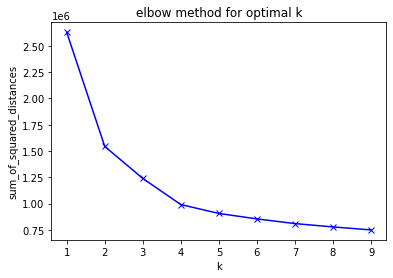

In [146]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [147]:
k_means = KMeans(n_clusters=4, random_state=15217)
model = k_means.fit(X_train_scaled)

In [148]:
X_train_predict = model.predict(X_train_scaled)
X_train_predict = pd.Series(X_train_predict, index=X_train.index)
X_train['Cluster'] = X_train_predict
X_train.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI-0,PIT_DHI-1,PIT_DHI-2,PIT_DHI-3,PIT_DNI-0,PIT_DNI-1,...,YGT_DHI-0,YGT_DHI-1,YGT_DHI-2,YGT_DHI-3,YGT_DNI-0,YGT_DNI-1,YGT_DNI-2,YGT_DNI-3,YGT_Surface Albedo-0,Cluster
0,0.382683,0.923880,0.017213,0.999852,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0
1,0.500000,0.866025,0.017213,0.999852,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0
2,0.608761,0.793353,0.017213,0.999852,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0
3,0.707107,0.707107,0.017213,0.999852,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0
4,0.793353,0.608761,0.017213,0.999852,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0


In [149]:
X_val = X_val[X_train_selected_columns]
X_val.columns

Index(['Time_X', 'Time_Y', 'Day_X', 'Day_Y', 'PIT_DHI-0', 'PIT_DHI-1',
       'PIT_DHI-2', 'PIT_DHI-3', 'PIT_DNI-0', 'PIT_DNI-1',
       ...
       'WHE_Wind_Y-0', 'YGT_DHI-0', 'YGT_DHI-1', 'YGT_DHI-2', 'YGT_DHI-3',
       'YGT_DNI-0', 'YGT_DNI-1', 'YGT_DNI-2', 'YGT_DNI-3',
       'YGT_Surface Albedo-0'],
      dtype='object', length=186)

In [150]:
X_val_scaled = X_train_scaler.transform(X_val).copy()

In [151]:
X_val_predict = model.predict(X_val_scaled)
X_val_predict = pd.Series(X_val_predict, index=X_val.index)
X_val['Cluster'] = X_val_predict
X_val.head()

,Time_X,Time_Y,Day_X,Day_Y,PIT_DHI-0,PIT_DHI-1,PIT_DHI-2,PIT_DHI-3,PIT_DNI-0,PIT_DNI-1,...,YGT_DHI-0,YGT_DHI-1,YGT_DHI-2,YGT_DHI-3,YGT_DNI-0,YGT_DNI-1,YGT_DNI-2,YGT_DNI-3,YGT_Surface Albedo-0,Cluster
0,0.608761,0.793353,0.493776,0.869589,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0
1,0.707107,0.707107,0.493776,0.869589,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0
2,0.793353,0.608761,0.493776,0.869589,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0
3,0.866025,0.500000,0.493776,0.869589,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0
4,0.923880,0.382683,0.493776,0.869589,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.866,0


In [152]:
# scale data
y_train_scaler = MinMaxScaler()
y_train_scaled = y_train_scaler.fit_transform(y_train)
y_val_scaled = y_train_scaler.transform(y_val)

In [153]:
X_train_cluster_0 = X_train[X_train['Cluster'] == 0]
X_train_cluster_1 = X_train[X_train['Cluster'] == 1]
X_train_cluster_2 = X_train[X_train['Cluster'] == 2]
X_train_cluster_3 = X_train[X_train['Cluster'] == 3]

X_val_cluster_0 = X_val[X_val['Cluster'] == 0]
X_val_cluster_1 = X_val[X_val['Cluster'] == 1]
X_val_cluster_2 = X_val[X_val['Cluster'] == 2]
X_val_cluster_3 = X_val[X_val['Cluster'] == 3]

In [154]:
y_train_cluster_0 = y_train.iloc[X_train_cluster_0.index.values]
y_train_cluster_1 = y_train.iloc[X_train_cluster_1.index.values]
y_train_cluster_2 = y_train.iloc[X_train_cluster_2.index.values]
y_train_cluster_3 = y_train.iloc[X_train_cluster_3.index.values]

y_val_cluster_0 = y_val.iloc[X_val_cluster_0.index.values]
y_val_cluster_1 = y_val.iloc[X_val_cluster_1.index.values]
y_val_cluster_2 = y_val.iloc[X_val_cluster_2.index.values]
y_val_cluster_3 = y_val.iloc[X_val_cluster_3.index.values]

In [155]:
X_train_cluster_0 = X_train_cluster_0.drop(['Cluster'], axis=1)
X_train_cluster_1 = X_train_cluster_1.drop(['Cluster'], axis=1)
X_train_cluster_2 = X_train_cluster_2.drop(['Cluster'], axis=1)
X_train_cluster_3 = X_train_cluster_3.drop(['Cluster'], axis=1)

X_val_cluster_0 = X_val_cluster_0.drop(['Cluster'], axis=1)
X_val_cluster_1 = X_val_cluster_1.drop(['Cluster'], axis=1)
X_val_cluster_2 = X_val_cluster_2.drop(['Cluster'], axis=1)
X_val_cluster_3 = X_val_cluster_3.drop(['Cluster'], axis=1)

In [156]:
X_train_cluster_0.reset_index(inplace=True, drop=True)
X_train_cluster_1.reset_index(inplace=True, drop=True)
X_train_cluster_2.reset_index(inplace=True, drop=True)
X_train_cluster_3.reset_index(inplace=True, drop=True)

y_train_cluster_0.reset_index(inplace=True, drop=True)
y_train_cluster_1.reset_index(inplace=True, drop=True)
y_train_cluster_2.reset_index(inplace=True, drop=True)
y_train_cluster_3.reset_index(inplace=True, drop=True)

In [157]:
X_train_cluster_0_norm = X_train_scaler.transform(X_train_cluster_0)
X_train_cluster_1_norm = X_train_scaler.transform(X_train_cluster_1)
X_train_cluster_2_norm = X_train_scaler.transform(X_train_cluster_2)
X_train_cluster_3_norm = X_train_scaler.transform(X_train_cluster_3)

y_train_cluster_0_norm = y_train_scaler.transform(y_train_cluster_0)
y_train_cluster_1_norm = y_train_scaler.transform(y_train_cluster_1)
y_train_cluster_2_norm = y_train_scaler.transform(y_train_cluster_2)
y_train_cluster_3_norm = y_train_scaler.transform(y_train_cluster_3)

X_val_cluster_0_norm = X_train_scaler.transform(X_val_cluster_0)
X_val_cluster_1_norm = X_train_scaler.transform(X_val_cluster_1)
X_val_cluster_2_norm = X_train_scaler.transform(X_val_cluster_2)
X_val_cluster_3_norm = X_train_scaler.transform(X_val_cluster_3)

y_val_cluster_0_norm = y_train_scaler.transform(y_val_cluster_0)
y_val_cluster_1_norm = y_train_scaler.transform(y_val_cluster_1)
y_val_cluster_2_norm = y_train_scaler.transform(y_val_cluster_2)
y_val_cluster_3_norm = y_train_scaler.transform(y_val_cluster_3)


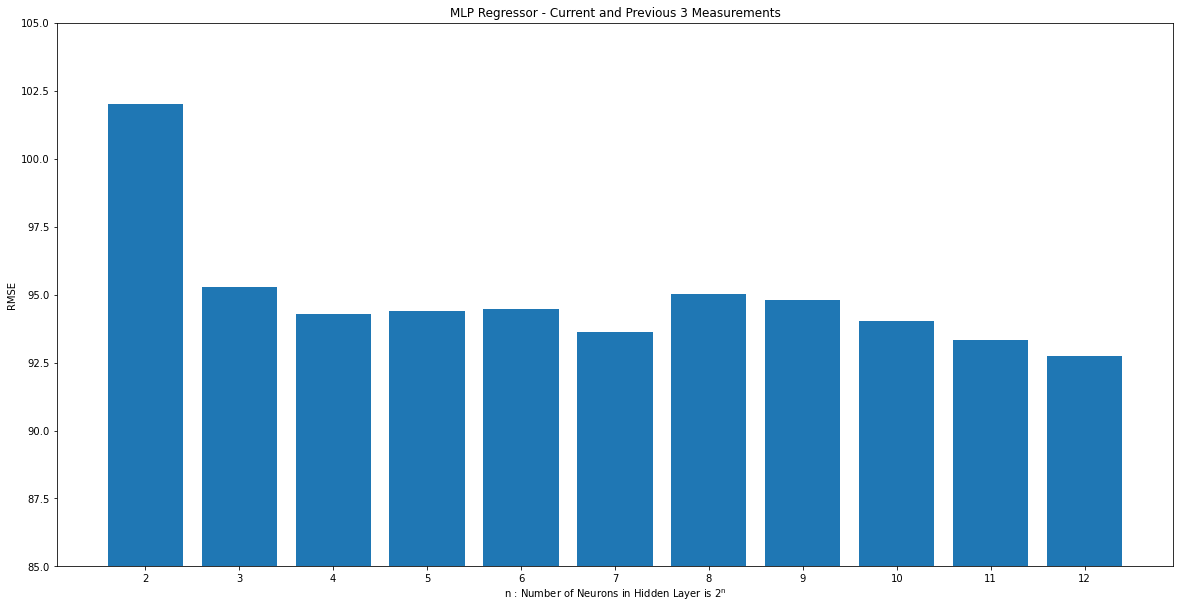

In [158]:
scores = []
scores_0 = []
scores_1 = []
scores_2 = []
scores_3 = []
num_neurons1 = range(2,13)
labels = []

for n1 in num_neurons1:
    model_0 = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
    model_1 = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
    model_2 = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
    model_3 = MLPRegressor(random_state = 15217, hidden_layer_sizes = (2**n1,), early_stopping=True, validation_fraction = 0.2, n_iter_no_change = 5)
    
    model_0.fit(X_train_cluster_0_norm, y_train_cluster_0_norm.ravel())
    model_1.fit(X_train_cluster_1_norm, y_train_cluster_1_norm.ravel())
    model_2.fit(X_train_cluster_2_norm, y_train_cluster_2_norm.ravel())
    model_3.fit(X_train_cluster_3_norm, y_train_cluster_3_norm.ravel())
    
    prediction_0 = model_0.predict(X_val_cluster_0_norm)
    prediction_1 = model_1.predict(X_val_cluster_1_norm)
    prediction_2 = model_2.predict(X_val_cluster_2_norm)
    prediction_3 = model_3.predict(X_val_cluster_3_norm)

    prediction_0 = y_train_scaler.inverse_transform(prediction_0.reshape(-1,1))
    prediction_1 = y_train_scaler.inverse_transform(prediction_1.reshape(-1,1))
    prediction_2 = y_train_scaler.inverse_transform(prediction_2.reshape(-1,1))
    prediction_3 = y_train_scaler.inverse_transform(prediction_3.reshape(-1,1))
    
    prediction = np.concatenate((prediction_0, prediction_1, prediction_2, prediction_3), axis=0)
    
    actual_0 = y_val_cluster_0
    actual_1 = y_val_cluster_1
    actual_2 = y_val_cluster_2
    actual_3 = y_val_cluster_3
    
    actual = actual_0.append(actual_1, ignore_index=True)
    actual = actual.append(actual_2, ignore_index=True)
    actual = actual.append(actual_3, ignore_index=True)
    
    score_0 = mean_squared_error(actual_0, prediction_0, squared=False)
    score_1 = mean_squared_error(actual_1, prediction_1, squared=False)
    score_2 = mean_squared_error(actual_2, prediction_2, squared=False)
    score_3 = mean_squared_error(actual_3, prediction_3, squared=False)
    
    scores_0.append(score_0)
    scores_1.append(score_1)
    scores_2.append(score_2)
    scores_3.append(score_3)
    
    scores.append(mean_squared_error(actual, prediction, squared=False))

    labels.append("{n1}".format(n1=n1))

fig = plt.figure(figsize=(20,10))

plt.title('MLP Regressor - Current and Previous 3 Measurements')
plt.xlabel('n : Number of Neurons in Hidden Layer is $\mathregular{2^{n}}$')
x = range(len(labels))
plt.xticks(x, labels)
plt.ylabel('RMSE')
plt.bar(labels, scores)
plt.ylim(85, 105) 
plt.show()

In [164]:
scores_0

[82.63058651141573,
 69.97960498395653,
 68.38247326099248,
 68.28116993430358,
 69.55400102405656,
 68.69293648582713,
 71.84604302909219,
 67.73072540468536,
 68.31565819296678,
 66.51427889451821,
 68.28900925801977]